In [4]:
# reload magic
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mldec.datasets import toy_problem_data, toric_code_data
from mldec.models import baselines
from mldec.utils import evaluation

### Toric code analysis notes



In [6]:
target = "transformer_toric_code_only_good_examples_results.csv"

df = pd.read_csv(target)
# df_cnn = pd.read_csv(target_cnn)


#### Tuning analysis: see which hyperparameters were good
 
 - March 22 only-good-examples
    - lr=0.001 was perfect(!) - every model with this learning rate did perfectly
    - d_model >= 16 will be better
    - dim_feedforward 8,16 not good
TO REMOVE:
    - d_model=4,8, dim_feedforward=8,16,lr=0.0001, 0.005
    - dim_feedforward 8,16 not good

In [7]:
# display unique lr values
print(df['lr'].unique())


[0.0001 0.0005 0.001  0.002  0.006 ]


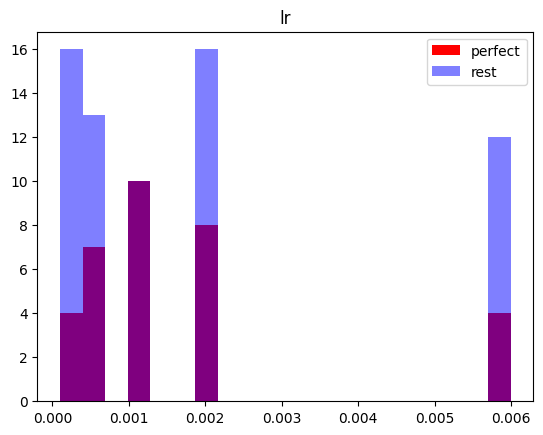

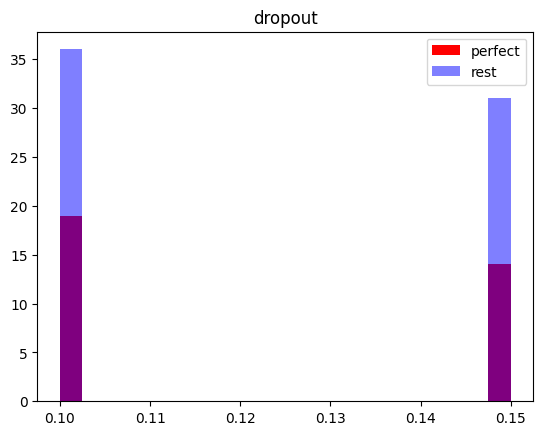

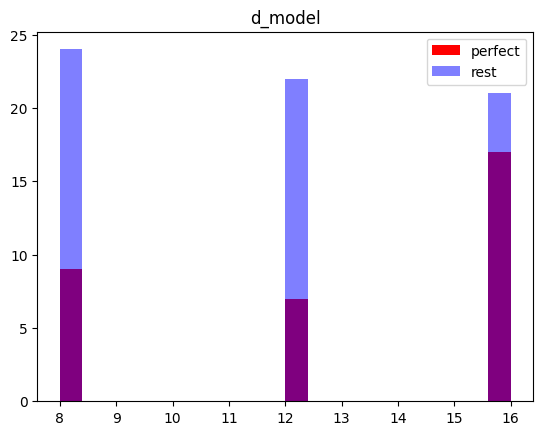

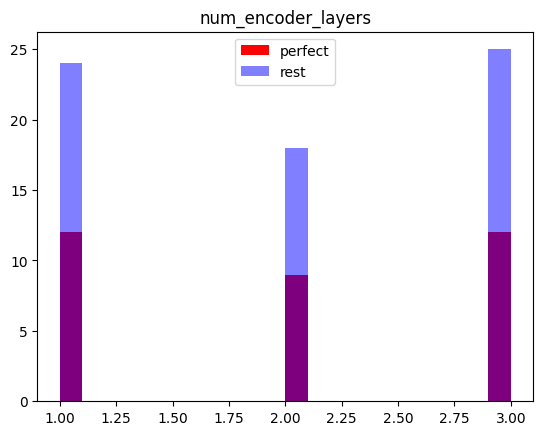

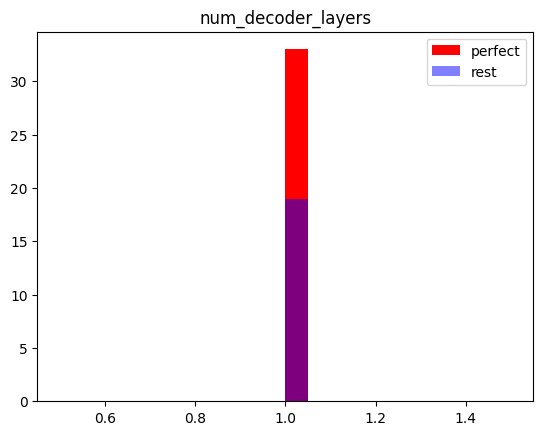

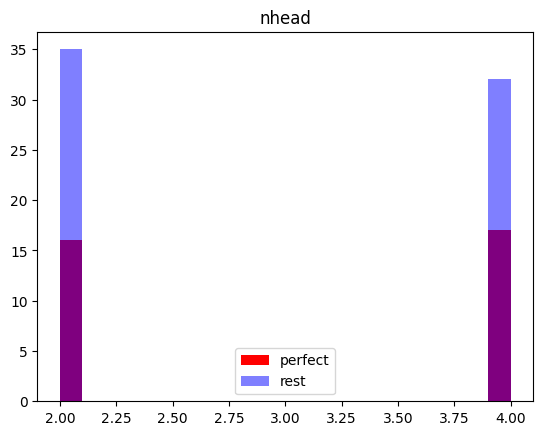

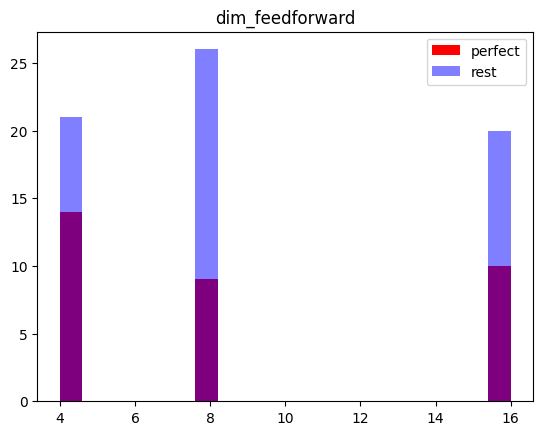

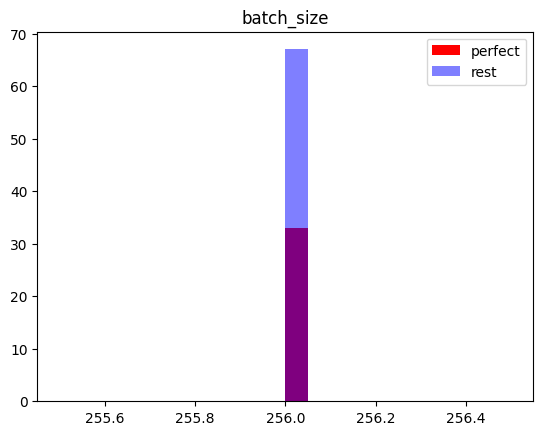

In [8]:
# histogram of 'val_acc' 
# df['val_acc'].hist(bins=20)
def compare_slice_by_column(df, column, slice_by):
    best = df[df[slice_by] == 1]
    other = df[df[slice_by] != 1]
    cts, bins, _ = plt.hist(best[column], bins=20, alpha=1, color='r', label='perfect')
    plt.hist(other[column], bins=bins, alpha=0.5, color='b', label='rest')
    plt.legend()
    plt.title(column)
    plt.show()

for column in ['lr', 'dropout', 'd_model', 'num_encoder_layers', 'num_decoder_layers', 'nhead', 'dim_feedforward', 'batch_size']:
    compare_slice_by_column(df, column, 'val_acc')

## Run analysis

In [9]:
target_var = "toric-code-var-exp/transformer_toric_code_results.csv"
target_novar = "toric-code-novar-exp/transformer_toric_code_results.csv"

df_var = pd.read_csv(target_var)
df_novar = pd.read_csv(target_novar)

In [11]:
# compute optimal performance on this dataset

ptrue = 0.05
var = 0.03
n = 9
dataset_config = {"p": ptrue, "var": var, "beta": 1.0}
X, Y, good_weights = toric_code_data.uniform_over_good_examples(n, dataset_config)
X, Y, true_weights = toric_code_data.create_dataset_training(n, dataset_config)

mld = baselines.LookupTable()
mld.train_on_histogram(X, Y, good_weights)
mld_acc = evaluation.weighted_accuracy(mld, X, Y, true_weights) 
print(f"MLD table accuracy: {mld_acc}")

# compute the MLD for a no-variance depolarizing noise model
mld_for_novar = []
betavals = sorted(df_novar['beta'].unique())
for beta in betavals:
    novar_dataset_config = {"p": ptrue, "var": 0, "beta": beta}
    X, Y, good_weights = toric_code_data.uniform_over_good_examples(n, novar_dataset_config)
    # train an MLD on the no-variance noise model, and then
    # evaluate on the "true" noise profile
    mld_novar = baselines.LookupTable()
    mld.train_on_histogram(X, Y, good_weights)
    acc_novar = evaluation.weighted_accuracy(mld, X, Y, true_weights)
    mld_for_novar.append(acc_novar)
    print(acc_novar)


MLD table accuracy: 0.9636911153793335
0.9606460928916931
0.9606460928916931
0.9606460928916931
0.9606460928916931
0.9606460928916931
0.9606460928916931
0.9606460928916931
0.9606460928916931
0.9606460928916931
0.9606460928916931


In [33]:
a = 0.03
b = 1.25
print(f"{a:4.3f}")
print(f"{b:4.3f}")

0.030
1.250


In [11]:
df_var.head()

,epoch,train_loss,train_acc,val_loss,val_acc,vs_lookup,vs_minweight,lr,d_model,dropout,num_encoder_layers,num_decoder_layers,nhead,dim_feedforward,batch_size,beta
0,4270,0.019099,0.981270,0.059413,0.958461,0.000511,0.006010,0.0005,24,0.10,3,1,4,4,256,0.75
1,2020,0.019063,0.981671,0.053928,0.960099,0.002946,0.007647,0.0010,24,0.10,2,1,2,8,256,0.75
2,4970,0.020468,0.980369,0.047636,0.960625,0.003472,0.008173,0.0030,16,0.15,1,1,2,8,256,0.75
3,1050,0.019173,0.981771,0.059443,0.960450,0.003297,0.007998,0.0005,20,0.15,3,1,4,8,256,0.75
4,1770,0.023008,0.979868,0.049789,0.959755,0.001805,0.007304,0.0020,16,0.10,2,1,4,8,256,0.75


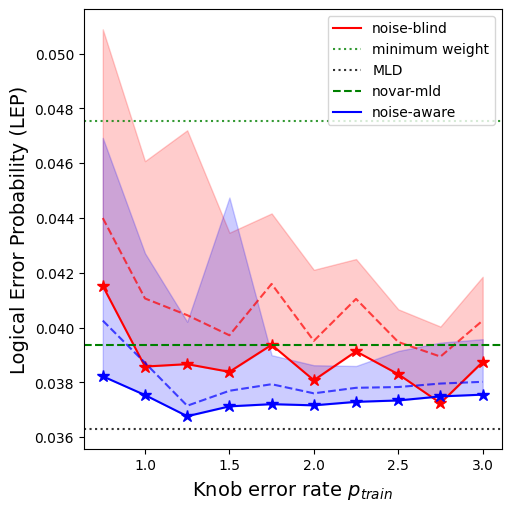

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True, constrained_layout=True)

colors = ['r', 'b']
labels = [ 'noise-blind', 'noise-aware']
for jj, df in enumerate([df_novar, df_var]):
    
    color = colors[jj]
    # compute performance/stats on each of the models
    betavals = sorted(df['beta'].unique())
    yerrs_meds = []
    yerrs_mins = []
    yerrs_ub = []
    yerrs_lb = []
    better_than_lookup_arr = [] # track when the model is better than the lookup table
    for i, beta in enumerate(betavals):
        y = df[df['beta'] == beta]['val_acc']
        y_err = 1 - y
        yerrs_meds.append(y_err.median())
        # get 
        # y_ub = y_err.quantile(.75)
        # y_lb = y_err.quantile(0.25)
        y_ub = max(y_err)
        y_lb = min(y_err)
        yerrs_ub.append(y_ub)
        yerrs_lb.append(y_lb)
        yerrs_mins.append(y_err.min())

        # Also get the min weight performance
        vs_minweight = df[df['beta'] == beta]['vs_minweight'].values
        minweight = y - vs_minweight
        min_minweight_err = min(np.round(1 - minweight, 7)) # machine precision errors from the subtraction op above...

        # now, find the comparison of this plot to the lookup table on the plot
        vs_lookup = df[df['beta'] == beta]['vs_lookup'][y.idxmax()]
        better_than_lookup = vs_lookup > 0
        better_than_lookup_arr.append(better_than_lookup)
    
    yerrs_meds = np.array(yerrs_meds)
    yerrs_mins = np.array(yerrs_mins)
    yerrs_ub = np.array(yerrs_ub)
    yerrs_lb = np.array(yerrs_lb)
    ax.fill_between(betavals, yerrs_lb, yerrs_ub, color=color, alpha=0.2)
    ax.plot(betavals, yerrs_meds, ls='--', marker=None, c=color, alpha=0.7)
    ax.plot(betavals, yerrs_mins, ls='-', marker=None, c=color, label=labels[jj])
    # wherever the result is better than lookup, plot a star
    for i, beta in enumerate(betavals):
        if better_than_lookup_arr[i]:
            marker = '*'
            markersize = 9
        else:
            marker = 'o'
            markersize = 6
        ax.plot(beta, yerrs_mins[i], marker=marker, c=color, markersize=markersize)

    ax.set_xlabel(r"Knob error rate $p_{train}$", size=14)
    if jj ==0:
        ax.axhline(min_minweight_err, ls=':', c='g', alpha=0.8, label='minimum weight')
        ax.axhline(1 - mld_acc, ls=':', c='k', alpha=0.8, label='MLD')
        ax.axhline(1 - 0.96064, ls='--', label='novar-mld', c='g')

# axes[0].set_ylim([9e-4, 2e-1])
ax.set_ylabel("Logical Error Probability (LEP)", size=14)
ax.legend(loc="upper right")
    
fig.savefig(f"../../figures/agg_toric_code.pdf", bbox_inches='tight')

Issues:
 - variance looks really small..?
 - what the fuck is the phase-looking stuff